**OVERVIEW**

**The goal of this project was to develop a predictive model for estimating house prices based on a range of features provided in the dataset. This project, hosted on Kaggle [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview), involved applying advanced regression techniques to a dataset of house sale prices in Ames, Iowa. The challenge was to build a model that can accurately predict house prices based on both numeric and categorical features.**

**Pre-Process and clean the data**

In [1]:
import gc
import numpy as np
from numpy import hstack
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

**Read and import datasets**

In [2]:
train = pd.read_csv('ames_data/train.csv', low_memory = False)

In [3]:
test = pd.read_csv('ames_data/test.csv', low_memory = False)

In [4]:
with open('ames_data/data_description.txt','r') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [5]:
#get number of columns in the train dataset
len(train.columns)

81

In [6]:
#get number of columns in the test dataset. It is missing the "SalePrice" column 
#as it was part of an ongoing kaggle competition
len(test.columns)

80

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Get correlation of numeric variables with the SalePrice as we are trying to predict the SalePrice. Remove variables(features) with less than 0.25 correlation with the SalePrice**

In [8]:
train.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

In [9]:
#get index of features(columns) with less than 0.25 correlation with the SalePrice.
#save it in a variable
column_drop = train.corr()['SalePrice'][abs(train.corr()['SalePrice'])<0.25].index

In [10]:
#Drop features(columns) with less than 0.25 correlation with the SalePrice in the
#train dataset
train = train.drop([column for column in column_drop],axis=1)

In [11]:
#Save the id from the test dataset as we will need it for the final submission of the
#SalePrice prediction
test_id = test["Id"]

In [12]:
#Drop features(columns) with less than 0.25 correlation with the SalePrice in the
#test dataset
test = test.drop([column for column in column_drop],axis=1)

**Remove basement categorical variables(features) that are not related square footage as numerical basement variables not related to squarefootage had low correlation to SalePrice**

In [13]:
#drop basement categorical variables(features) that are not related square footage in train
bsmt_str_cols = ['BsmtFinType1','BsmtFinType2','BsmtExposure']
train = train.drop(bsmt_str_cols,axis=1)

In [14]:
#drop basement categorical variables(features) that are not related square footage in test
test = test.drop(bsmt_str_cols,axis=1)

**Make scatterplot to remove outliers in the training dataset**

<AxesSubplot:title={'center':'Sale Price vs Overall Quality'}, xlabel='OverallQual', ylabel='SalePrice'>

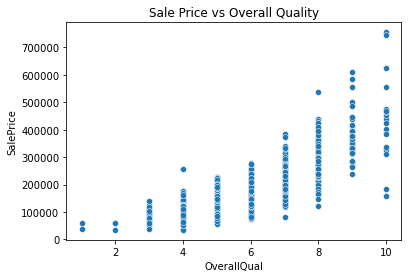

In [15]:
#make a scatterplot with overall quality and sale price
plt.title('Sale Price vs Overall Quality')
sns.scatterplot(x='OverallQual',y='SalePrice',data=train)

<AxesSubplot:title={'center':'Sale Price vs Greater Living Area'}, xlabel='GrLivArea', ylabel='SalePrice'>

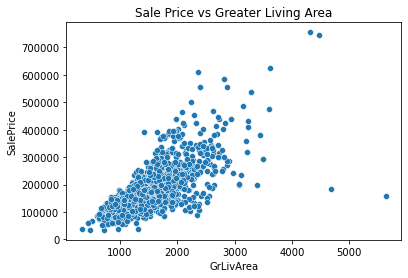

In [16]:
#make a scatterplot with overall quality and sale price
plt.title('Sale Price vs Greater Living Area')
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train)

In [17]:
#get index of outlier points on OverallQual
train[(train['OverallQual']>8)&(train['SalePrice']<250000)].index

Int64Index([523, 963, 1298], dtype='int64')

In [18]:
#get index of outlier points on GrLivArea
train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index

Int64Index([523, 1298], dtype='int64')

In [19]:
#save index of outlier points of OverallQual into variable
exclude_ind = train[(train['OverallQual']>8)&(train['SalePrice']<250000)].index

In [20]:
#remove index of outlier points of OverallQual from train data
train = train.drop(exclude_ind, axis = 0)

**Get percentage of null values within each column to choose additional columns to drop**

In [21]:
#make function to determine columns where percentage of null values is higher than 0
def percent_missing(df):
    percent_missing = 100*df.isnull().sum()/len(df)
    percent_missing = percent_missing[percent_missing>0].sort_values()
    return percent_missing

In [22]:
#put data through function and save in variable
percent_missing = percent_missing(train)

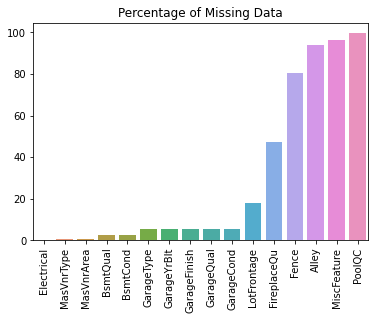

In [23]:
#show columns where percentage of null values is higher than 0
sns.barplot(x=percent_missing.index,y =percent_missing)
plt.xticks(rotation=90)
plt.title('Percentage of Missing Data')
plt.show()


In [24]:
#drop 'PoolQC', 'MiscFeature','Alley','Fence' from train data as percentage of null values is higher than 80
train = train.drop(['PoolQC', 'MiscFeature','Alley','Fence'], axis=1)

In [25]:
#drop 'PoolQC', 'MiscFeature','Alley','Fence' from test data as percentage of null values is higher than 80
test = test.drop(['PoolQC', 'MiscFeature','Alley','Fence'], axis=1)

**Drop categorical columns 'MasVnrType' (Masonry veneer type) ,'MasVnrArea' (Masonry veneer area sq feet' as they hold little importance in home buying factors.**

In [26]:
#drop 'MasVnrType','MasVnrArea' from train data
train = train.drop(['MasVnrType','MasVnrArea'],axis=1)

In [27]:
#drop 'MasVnrType','MasVnrArea' from test data
test = test.drop(['MasVnrType','MasVnrArea'], axis=1)

In [28]:
train[['BsmtQual','BsmtCond','Electrical']] = train[['BsmtQual','BsmtCond','Electrical']].fillna('None')

In [29]:
test[['BsmtQual','BsmtCond','Electrical']] = test[['BsmtQual','BsmtCond','Electrical']].fillna('None')

**Impute values into rows where there are missing values in the train dataset**

In [30]:
gar_str_cols = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]

In [31]:
train[gar_str_cols].isnull().sum()

GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In [32]:
train[gar_str_cols] = train[gar_str_cols].fillna('None')

In [33]:
test[gar_str_cols] = test[gar_str_cols].fillna('None')

In [34]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

In [35]:
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

In [36]:
percent_missing = 100*train.isnull().sum()/len(train)
percent_missing = percent_missing[percent_missing>0].sort_values()
percent_missing

LotFrontage    17.776253
FireplaceQu    47.288950
dtype: float64

In [37]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')

In [38]:
test['FireplaceQu'] = test['FireplaceQu'].fillna('None')

In [39]:
train['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1457, dtype: float64

<AxesSubplot:xlabel='LotFrontage', ylabel='Neighborhood'>

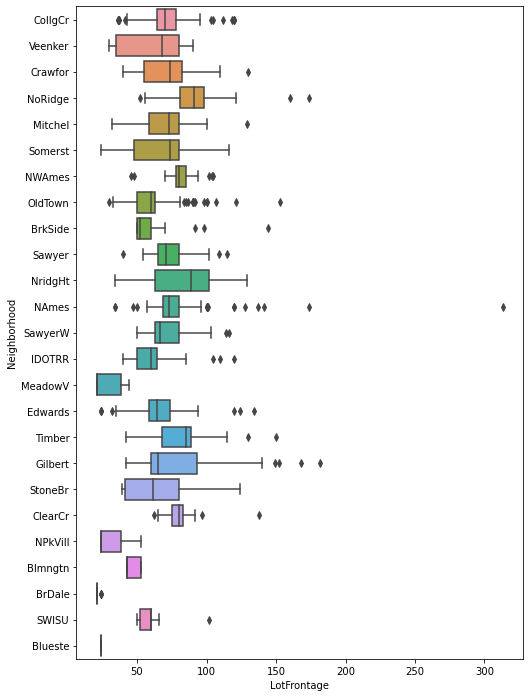

In [40]:
plt.figure(figsize=(8,12))
sns.boxplot(x='LotFrontage', y='Neighborhood', data=train, orient='h')

In [41]:
#replace null values with groupby mean

In [42]:
train.groupby('Neighborhood')['LotFrontage'].mean()

Neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.562500
BrkSide    57.509804
ClearCr    83.461538
CollgCr    71.280000
Crawfor    71.804878
Edwards    64.811111
Gilbert    79.877551
IDOTRR     62.500000
MeadowV    27.800000
Mitchel    70.083333
NAmes      76.462366
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.881579
OldTown    62.788991
SWISU      58.913043
Sawyer     74.437500
SawyerW    71.500000
Somerst    64.666667
StoneBr    62.700000
Timber     80.133333
Veenker    59.714286
Name: LotFrontage, dtype: float64

In [43]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda value: value.fillna(value.mean()))

In [44]:
#check for any null values in train data
train.isnull().sum()

MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtFinSF1       0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
SaleType    

**Impute values into rows where there are missing values in the train dataset**

In [45]:
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda value: value.fillna(value.mean()))

In [46]:
test.isnull().sum()

MSZoning         4
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        2
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtFinSF1       1
TotalBsmtSF      1
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
KitchenQual      1
TotRmsAbvGrd     0
Functional       2
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       1
GarageArea       1
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
SaleType    

In [47]:
test["MSZoning"].unique()

array(['RH', 'RL', 'RM', 'FV', 'C (all)', nan], dtype=object)

In [48]:
test['MSZoning'] = test.groupby('Neighborhood')['MSZoning'].transform(lambda value: value.fillna(value.mode()[0]))

In [49]:
test["Utilities"] = test["Utilities"].fillna('AllPub')

In [50]:
test["Utilities"].unique()

array(['AllPub'], dtype=object)

In [51]:
test["Exterior1st"].unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
       'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
       nan, 'CBlock'], dtype=object)

In [52]:
test['Exterior1st'] = test.groupby('Neighborhood')['Exterior1st'].transform(lambda value: value.fillna(value.mode()[0]))

In [53]:
test['Exterior2nd']= test.groupby('Neighborhood')['Exterior2nd'].transform(lambda value: value.fillna(value.mode()[0]))

In [54]:
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)

In [55]:
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)

In [56]:
test[test['GarageCars'].isnull()]

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition
1116,RM,50.0,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,None,NaN,NaN,None,None,Y,174,0,WD,Alloca


In [57]:
test['GarageCars']=test['GarageCars'].fillna(0)

In [58]:
test['GarageArea']=test['GarageArea'].fillna(0)

In [59]:
test['SaleType'].unique()

array(['WD', 'COD', 'New', 'ConLD', 'Oth', 'Con', 'ConLw', 'ConLI', 'CWD',
       nan], dtype=object)

In [60]:
test[test['SaleType'].isnull()]['YearBuilt']

1029    1958
Name: YearBuilt, dtype: int64

In [61]:
test['SaleType'].value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
ConLI       4
Oth         4
ConLw       3
Con         3
Name: SaleType, dtype: int64

In [62]:
test['SaleType'] = test['SaleType'].fillna('WD')

**fill row with'KitchenQual' null values with 'GarageQual' null values

In [63]:
test[test['KitchenQual'].isna()]['GarageQual']

95    Fa
Name: GarageQual, dtype: object

In [64]:
test['KitchenQual'] = test['KitchenQual'].fillna('Fa')

In [65]:
test['Functional'].unique()

array(['Typ', 'Min2', 'Min1', 'Mod', 'Maj1', 'Sev', 'Maj2', nan],
      dtype=object)

In [66]:
test["Functional"].value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [67]:
test["Functional"]=test["Functional"].fillna('Typ')

**Separate train dataset by numerical and object features and make dummy features for object features**

In [68]:
train_object = train.select_dtypes(include='object')

In [69]:
train_numeric = train.select_dtypes(exclude = 'object')

In [70]:
train_objects_dummies = pd.get_dummies(train_object,drop_first=True)

**Concatenate numerical and dummy features for train dataset**

In [71]:
train_combined = pd.concat([train_numeric,train_objects_dummies], axis = 1)

**Make X train dataset by dropping SalePrice column**

In [72]:
X_train = train_combined.drop("SalePrice", axis=1)

**Separate test dataset by numerical and object features and make dummy features for object features**

In [73]:
test_object = test.select_dtypes(include='object')

In [74]:
test_numeric = test.select_dtypes(exclude = 'object')

In [75]:
test_objects_dummies = pd.get_dummies(test_object,drop_first=True)

**Concatenate numerical and dummy features for test dataset**

In [76]:
test_combined = pd.concat([test_numeric,test_objects_dummies], axis = 1)

**Find list of dummy feature columns that exist on the train dataset that are missing in the test dataset**

In [77]:
missing_list = list(set(X_train)-set(test_combined))

**Make a dataset with dummy feature columns that are missing in the test dataset filled with zeros**

In [78]:
test_dummy_add = pd.DataFrame(0.0,index=range(len(test_combined)),columns=missing_list)

In [79]:
test_dummy_add.shape

(1459, 16)

**Add the dataset with dummy feature columns that are missing into the test dataset**

In [80]:
test_combined_dummies = pd.concat([test_combined,test_dummy_add], axis = 1)

In [81]:
test_combined_dummies

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Condition2_RRAn,Electrical_Mix,Condition2_RRAe,Condition2_RRNn,HouseStyle_2.5Fin,Heating_OthW,Utilities_NoSeWa,Electrical_None,RoofMatl_Roll,Exterior1st_ImStucc
0,80.0,11622,5,1961,1961,468.0,882.0,896,0,896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81.0,14267,6,1958,1958,923.0,1329.0,1329,0,1329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.0,13830,5,1997,1998,791.0,928.0,928,701,1629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78.0,9978,6,1998,1998,602.0,926.0,926,678,1604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.0,5005,8,1992,1992,263.0,1280.0,1280,0,1280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,4,1970,1970,0.0,546.0,546,546,1092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,21.0,1894,4,1970,1970,252.0,546.0,546,546,1092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,160.0,20000,5,1960,1996,1224.0,1224.0,1224,0,1224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,62.0,10441,5,1992,1992,337.0,912.0,970,0,970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
test_combined_dummies.isnull().sum()

LotFrontage            0
LotArea                0
OverallQual            0
YearBuilt              0
YearRemodAdd           0
                      ..
Heating_OthW           0
Utilities_NoSeWa       0
Electrical_None        0
RoofMatl_Roll          0
Exterior1st_ImStucc    0
Length: 210, dtype: int64

**Make X train data by dropping SalePrice column. Make y train data with the SalePrice column. The X test does not need this process as the the test data does not have the SalePrice column. (The y predicted values are compared when a csv file with the predictions are submitted into Kaggle.)**

In [83]:
X_train = train_combined.drop('SalePrice', axis =1)

In [84]:
y_train = train_combined["SalePrice"]

In [85]:
X_test = test_combined_dummies

**Make function to scale (standardize) the data**

In [86]:
def standardize(column):
    if column.std()==0:
        return column - column.mean()
    return (column - column.mean())/column.std()

In [87]:
X_train_scaled = X_train.apply(standardize)

In [88]:
y_train_scaled = (y_train - y_train.mean())/y_train.std()

**Fit train data into Elastic Net model. Use GridSearchCV to find the best parameters.**

In [89]:
from sklearn.linear_model import ElasticNet
model_1 = ElasticNet()

In [90]:
param_grid = {'alpha':[0.1,1,5,10,50,100,500,1000],'l1_ratio':[0.1,0.5,0.7,0.95,0.99,1]}

In [91]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [92]:
grid_model = GridSearchCV(estimator=model_1,
                         param_grid = param_grid,
                         scoring = 'neg_mean_squared_error',
                         cv=5,
                         verbose=1,return_train_score=True)

In [93]:
grid_model.fit(X_train_scaled,y_train_scaled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100, 500, 1000],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.95, 0.99, 1]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [94]:
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.1)

In [95]:
grid_model.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [96]:
np.sqrt(-1*grid_model.best_score_)

0.33692945405158603

**Fit train data into Random Forest model. Use GridSearchCV to find the best parameters.**

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
model_2 = RandomForestRegressor(random_state=8)

In [99]:
param_grid_2 = {'max_depth':[5,10,15],'n_estimators':[100,250,500],'min_samples_split':[3,5,10]}

In [100]:
grid_model_2 = GridSearchCV(estimator=model_2,
                         param_grid = param_grid_2,
                         cv=5,
                         scoring = 'neg_mean_squared_error',
                         n_jobs=-1,
                         )

In [101]:
grid_model_2.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=8), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [102]:
grid_model_2.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [103]:
np.sqrt(-1*grid_model_2.best_score_)

0.33601587640407937

**Fit train data into Gradient Boost model. Use GridSearchCV to find the best parameters.**

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

In [105]:
model_3 = GradientBoostingRegressor(random_state = 8)

In [106]:
param_grid_3 = {'max_depth':[12,15,20],
                'n_estimators':[200,300],
                'min_samples_leaf':[10,25],
                'learning_rate':[0.001,0.01,0.1],
                'max_features':[0.01,0.1,0.7]}

In [107]:
grid_model_3 = GridSearchCV(estimator=model_3,
                         param_grid = param_grid_3,
                         cv=5,
                         scoring = 'neg_mean_squared_error',
                         n_jobs=-1,
                         )

In [108]:
grid_model_3.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25],
                         'n_estimators': [200, 300]},
             scoring='neg_mean_squared_error')

In [109]:
np.sqrt(-1*grid_model_3.best_score_)

0.2981138955626299

**Fit train data into Ridge model. Use GridSearchCV to find the best parameters.**

In [110]:
from sklearn.linear_model import Ridge
model_4 = Ridge()

In [111]:
param_grid_4 = {'alpha':[0.05,0.1,1,3,5,10],'solver':['auto','svd','cholesky','lsqr','sparse_cg','sag']}

In [112]:
grid_model_4 = GridSearchCV(estimator=model_4,
                         param_grid = param_grid_4,
                         cv=5,
                         scoring = 'neg_mean_squared_error',
                         n_jobs=-1,
                         )

In [113]:
grid_model_4.fit(X_train_scaled,y_train_scaled)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [114]:
np.sqrt(-1*grid_model_4.best_score_)

0.33275505488012724

**Use Voting Regressor to combine all 4 models. Overall accuracy is improved by averaging the predictions of each model. Extra weight was put on the Gradient Boost model as it had the smallest root mean squared error out of all the models**

In [115]:
from sklearn.ensemble import VotingRegressor

In [116]:
votingregressor = VotingRegressor([
    ('ElasticNet', grid_model.best_estimator_),
    ('RandomForest', grid_model_2.best_estimator_),
    ('GradientBoost', grid_model_3.best_estimator_),
    ('Ridge', grid_model_4.best_estimator_)],
    weights = [1,1,2,1]
)

In [117]:
votingregressor.fit(X_train_scaled,y_train_scaled)

VotingRegressor(estimators=[('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.1)),
                            ('RandomForest',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_split=3,
                                                   n_estimators=500,
                                                   random_state=8)),
                            ('GradientBoost',
                             GradientBoostingRegressor(max_depth=15,
                                                       max_features=0.1,
                                                       min_samples_leaf=10,
                                                       n_estimators=300,
                                                       random_state=8)),
                            ('Ridge', Ridge(alpha=10, solver='sag'))],
                weights=[1, 1, 2, 1])

In [118]:
X_test_scaled = X_test.apply(standardize)

In [119]:
y_pred_scaled = votingregressor.predict(X_test_scaled)

In [120]:
def unstandardize(column, original_column):
    return column*original_column.std()+original_column.mean()

In [121]:
y_pred = unstandardize(y_pred_scaled, y_train)

In [122]:
submission_1 = pd.DataFrame({"Id":test_id, "SalePrice":y_pred.round(2)})

In [123]:
submission_1.to_csv("submission.csv", index=False)

**Submission had a log nrmse 0.17199, ranking 3594 out of 4770 submissions**